<a href="https://colab.research.google.com/github/Val3nt-ML/Kaggle-Competitions/blob/master/Kaggle_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
!nvcc --version
#!ls /content/gdrive/My\ Drive/collaborative-rnn/*.py
#!cat '/content/gdrive/My Drive/collaborative-rnn/crnn.py'
sys.path.append('/content/gdrive/My Drive/Kaggle/Titanic/')

import pandas as pd
pd.set_option('display.max_columns', 16)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split

## **Pré-Traitement des données**

In [0]:
df=pd.read_csv("/content/gdrive/My Drive/Kaggle/Titanic/train.csv")
df_test=pd.read_csv("/content/gdrive/My Drive/Kaggle/Titanic/test.csv")

df_all=pd.concat([df,df_test])
print(df_all.count)
#print(df.dtypes)

<bound method DataFrame.count of       Age Cabin Embarked      Fare  \
0    22.0   NaN        S    7.2500   
1    38.0   C85        C   71.2833   
2    26.0   NaN        S    7.9250   
3    35.0  C123        S   53.1000   
4    35.0   NaN        S    8.0500   
..    ...   ...      ...       ...   
413   NaN   NaN        S    8.0500   
414  39.0  C105        C  108.9000   
415  38.5   NaN        S    7.2500   
416   NaN   NaN        S    8.0500   
417   NaN   NaN        C   22.3583   

                                                  Name  Parch  PassengerId  \
0                              Braund, Mr. Owen Harris      0            1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                               Heikkinen, Miss. Laina      0            3   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                             Allen, Mr. William Henry      0            5   
..                                        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [0]:
print(df_all.count)
print("Valeurs Manquantes de DF_Train avant processing: \n")
print(df.isna().sum())
print("\n")

<bound method DataFrame.count of       Age Cabin Embarked      Fare  \
0    22.0   NaN        S    7.2500   
1    38.0   C85        C   71.2833   
2    26.0   NaN        S    7.9250   
3    35.0  C123        S   53.1000   
4    35.0   NaN        S    8.0500   
..    ...   ...      ...       ...   
413   NaN   NaN        S    8.0500   
414  39.0  C105        C  108.9000   
415  38.5   NaN        S    7.2500   
416   NaN   NaN        S    8.0500   
417   NaN   NaN        C   22.3583   

                                                  Name  Parch  PassengerId  \
0                              Braund, Mr. Owen Harris      0            1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                               Heikkinen, Miss. Laina      0            3   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                             Allen, Mr. William Henry      0            5   
..                                        

S    914
C    270
Q    123
Name: Embarked, dtype: int64

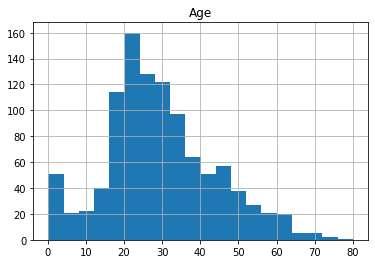

In [0]:
df_all.hist(column=['Age'], bins=20)
df_all.Embarked.value_counts()

On peut remarquer que:
  -Age: environ Distribution Normale => On remplace les NA par la valeur médiane
  -Embarked: S est la classe majoritaire, on peut remplacer les 2 valeurs manquantes par cette classe.
  -Cabin: On a 77% de valeurs manquantes


On peut remarquer que la variable Cabin est manquante dans 77% des cas, on peut donc raisonnablement faire le choix de ne pas tenir compte de cette variable.

# **Processing de la variable 'Name':** Ajout de la variable Title

In [0]:
#Converti le String Name en son nombre de caractères 
#df['Name'] = df['Name'].apply(len)
#df_test['Name'] = df_test['Name'].apply(len)

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    #Donnée n° 1305 ayant pour titre "Dona"
    "Dona"  : "Other"
}

def get_titles(combined):
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    combined.drop('Name', axis=1, inplace=True)
    return combined

get_titles(df_all)

df_all.head()
print(df_all.shape)

print(df_all[df_all['Title'].isnull()])

(1309, 12)
Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, Title]
Index: []


*On cherche à afficher l'age median des passagers en fonction de leur sexe, leur classe et leur Titre*

In [0]:
grouped_train = df_all.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
print(grouped_median_train)

       Sex  Pclass    Title   Age
0   female       1     Miss  30.0
1   female       1      Mrs  40.0
2   female       1  Officer  49.0
3   female       1  Royalty  40.5
4   female       2     Miss  24.0
5   female       2      Mrs  31.5
6   female       3     Miss  18.0
7   female       3      Mrs  31.0
8     male       1   Master   4.0
9     male       1       Mr  40.0
10    male       1  Officer  51.0
11    male       1  Royalty  40.0
12    male       2   Master   1.0
13    male       2       Mr  31.0
14    male       2  Officer  46.5
15    male       3   Master   4.0
16    male       3       Mr  26.0


# **Processing de la variable 'Age'**


In [0]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df_all
    # a function that fills the missing values of the Age variable
    df_all['Age'] = df_all.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return df_all

df_all = process_age()

In [0]:
print(df_all.isna().sum())

Age               0
Cabin          1014
Embarked          2
Fare              1
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
dtype: int64


# **Processing de la variable 'Fare'**

On remplace la variable 'Fare' manquante par la valeur de la moyenne des 'Fare' du **Training Set**.

In [0]:
def process_fare():    
  global df_all
  # there's one missing fare value - replacing it with the mean.
  df_all.Fare.fillna(df_all.iloc[:891].Fare.mean(), inplace=True)
  return df_all

df_all=process_fare()

In [0]:
print(df_all.isna().sum())

Age               0
Cabin          1014
Embarked          2
Fare              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
Title             0
dtype: int64


# **Processing de la variable 'Embarked**


In [0]:
#Traitement variable 'Embarked'
def process_embarked():
  global df_all
  df_all.Embarked.fillna(value='S', inplace=True)

  return df_all

df_all= process_embarked()

# **Processing de la variable 'Cabin'**

Remplacement de la variable Cabin par la première lettre A, B , C etc.. si la variable est présente, sinon est est remplacée par la lettre U qui correspond à Unknown.

In [0]:
def process_cabin():
    global df_all  
    # replacing missing cabins with U (for Uknown)
    df_all.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df_all['Cabin'] = df_all['Cabin'].map(lambda c: c[0])
    return df_all

df_all = process_cabin()

In [0]:
print(df_all.isna().sum())

Age              0
Fare             0
Parch            0
PassengerId      0
Pclass           0
                ..
Title_Mr         0
Title_Mrs        0
Title_Officer    0
Title_Other      0
Title_Royalty    0
Length: 69, dtype: int64


# **Processing de la variable 'Ticket'**

In [0]:
def process_ticket():
    
    global df_all
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'

    df_all['Ticket'] = df_all['Ticket'].map(cleanTicket)
    #df_all.drop('Ticket', inplace=True, axis=1)

    return df_all

df_all = process_ticket()

# **Création de la variable 'FamilySize'**

In [0]:
def process_family():
    
    global df_all
    # introducing a new feature : the size of families (including the passenger)
    df_all['FamilySize'] = df_all['Parch'] + df_all['SibSp'] + 1
    
    # introducing other features based on the family size
    df_all['Singleton'] = df_all['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df_all['SmallFamily'] = df_all['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df_all['LargeFamily'] = df_all['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

    return df_all

df_all = process_family()

### **Ajout de la variable 'Child'**

In [0]:
def IsChild(age):
  if(age<8):
    return(1)
  else:
    return(0)

df_all['Child']= df_all['Age'].apply(IsChild)
df_all.head()
print(df_all.shape)

(1309, 17)


In [0]:
df_all.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,...,Survived,Ticket,Title,FamilySize,Singleton,SmallFamily,LargeFamily,Child
0,22.0,U,S,7.2500,0,1,3,male,...,0.0,A5,Mr,2,0,1,0,0
1,38.0,C,C,71.2833,0,2,1,female,...,1.0,PC,Mrs,2,0,1,0,0
2,26.0,U,S,7.9250,0,3,3,female,...,1.0,STONO2,Miss,1,1,0,0,0
3,35.0,C,S,53.1000,0,4,1,female,...,1.0,XXX,Mrs,2,0,1,0,0
4,35.0,U,S,8.0500,0,5,3,male,...,0.0,XXX,Mr,1,1,0,0,0


In [0]:

#Transform Categorical Variables to Ordinal Variables
def deal_categorical_variables(df):
  df['Sex'] = df['Sex'].astype('category')
  df['Sex']= df['Sex'].cat.codes

  #Variable 'Embarked'
  embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
  df = pd.concat([df, embarked_dummies], axis=1)
  df.drop('Embarked', axis=1, inplace=True)

  #Variable 'Cabin'
  cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
  df = pd.concat([df, cabin_dummies], axis=1)
  df.drop('Cabin', axis=1, inplace=True)

  #Variable 'Ticket'
  ticket_dummies = pd.get_dummies(df['Ticket'], prefix='Ticket')
  df = pd.concat([df, ticket_dummies], axis=1)
  df.drop('Ticket', axis=1, inplace=True)

  #Variable 'Title'
  title_dummies = pd.get_dummies(df['Title'], prefix='Title')
  df = pd.concat([df, title_dummies], axis=1)
  df.drop('Title', axis=1, inplace=True)

  return df

df_all= deal_categorical_variables(df_all)
df_all.head()


df_train=df_all.iloc[:891]
df_test=df_all.iloc[891:]


print("Training DataFrame:")
print(df_all.head(5))

print("Df Train Shape: "+str(df_train.shape))
print("Df Test Shape: "+str(df_test.shape))

Training DataFrame:
    Age     Fare  Parch  PassengerId  Pclass  Sex  SibSp  Survived  ...  \
0  22.0   7.2500      0            1       3    1      1       0.0  ...   
1  38.0  71.2833      0            2       1    0      1       1.0  ...   
2  26.0   7.9250      0            3       3    0      0       1.0  ...   
3  35.0  53.1000      0            4       1    0      1       1.0  ...   
4  35.0   8.0500      0            5       3    1      0       0.0  ...   

   Ticket_XXX  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
0           0             0           0         1          0              0   
1           0             0           0         0          1              0   
2           0             0           1         0          0              0   
3           1             0           0         0          1              0   
4           1             0           0         1          0              0   

   Title_Other  Title_Royalty  
0            0        

# **Equilibrage des classes**

In [0]:
#df.hist(column=['Survived'])
from sklearn import preprocessing
"""
alive=df_train[df.Survived==1]
dead=df_train[df.Survived==0]

dead_downsampled=resample(dead, replace=False, 
                                  n_samples=len(alive), #Match Minority
                                  random_state=42) #Reproductible Result
df_train_final=pd.concat([dead_downsampled, alive])
df_train_final = shuffle(df_train_final)
#df_final.hist(column=['Survived'])
"""
X_train=df_train.drop('Survived' , axis=1)
X_train.drop('PassengerId', axis=1, inplace=True)
y_train=df_train.Survived



X_test=df_test.drop('Survived' , axis=1)
X_test.drop('PassengerId' , axis=1, inplace=True)

print("X_train Shape :"+str(X_train.shape))
print("y_train Shape :"+str(y_train.shape))
print("X_test Shape :"+str(X_test.shape))

X_train Shape :(891, 67)
y_train Shape :(891,)
X_test Shape :(418, 67)


# **Machine Learning Models**

In [0]:
from sklearn.model_selection import cross_val_score
import numpy as np


def compute_score(clf, scoring='accuracy', x_train= X_train):
    xval = cross_val_score(clf, x_train, y_train, cv = 5, scoring=scoring)

    y_pred=clf.predict(x_train)

    results=[np.mean(xval), metrics.f1_score(y_train, y_pred), metrics.roc_auc_score(y_train, y_pred), metrics.classification_report(y_train, y_pred, output_dict=False)]
    #results=[metrics.accuracy_score(y_train, y_pred), metrics.f1_score(y_train, y_pred), metrics.roc_auc_score(y_train, y_pred)]
    print('Accuracy score: %.2f' % results[0]) 
    print('F1 score: %.2f' % results[1])
    print('AUC score: %.2f' % results[2])
    #print('Log Loss score: %.2f' % results[1])
    #print('R2 score: %.2f' % results[2])
    #print('Mean Absolute Error: %.2f'% results[3]) 
    #print('Mean Squared Error: %.2f'% results[4])
    return results

## Regression Logistique


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Lr=LogisticRegression(solver='lbfgs')
#Entrainement du modèle
Lr.fit(X_train, y_train)

scores_lr=compute_score(Lr)
print(scores_lr[0])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy score: 0.83
F1 score: 0.79
AUC score: 0.83
0.8260857291703239


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


***SVM***

In [0]:
from sklearn import svm

svm = svm.SVC(gamma= 'auto',probability = True) 
#Entrainement du modèle
svm.fit(X_train, y_train)
#Obtention des scores
scores_svm=compute_score(svm)

Accuracy score: 0.73
F1 score: 0.79
AUC score: 0.83


***Random Forest***

In [0]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 

rf = RandomForestClassifier(n_estimators=50, max_features='sqrt' , criterion= 'gini', max_depth=15, random_state=42) 
#Entrainement du modèle
rf.fit(X_train, y_train)
#Obtention des scores
scores_rf=compute_score(rf)

Accuracy score: 0.82
F1 score: 0.95
AUC score: 0.96


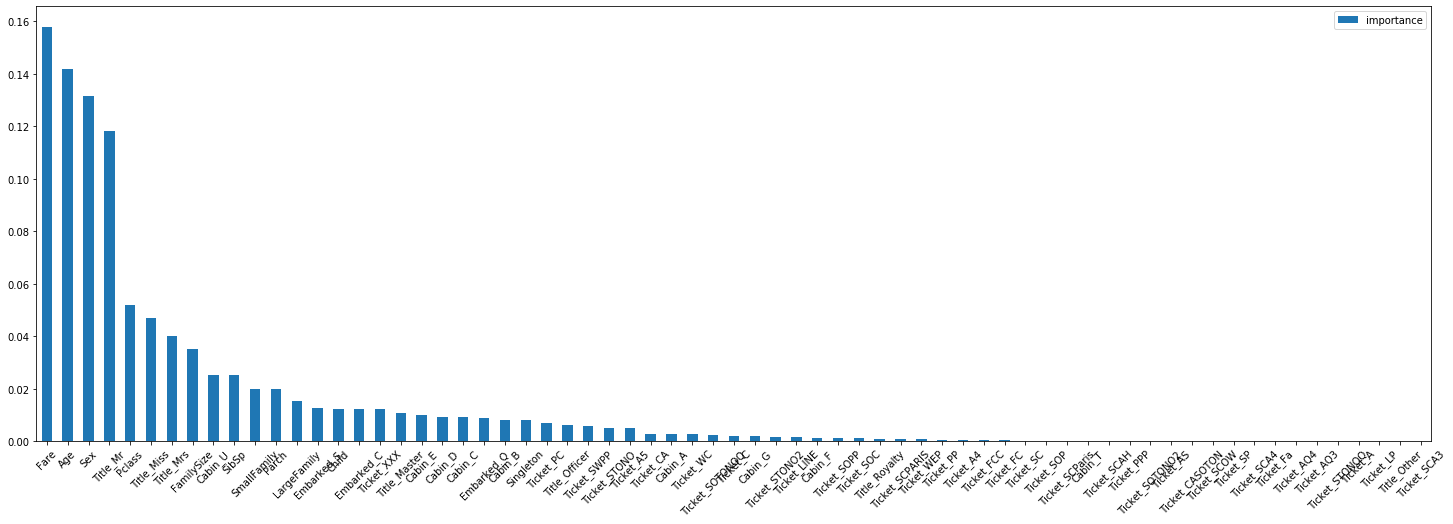

In [0]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
columns=['importance']). sort_values('importance', ascending=False)

feature_importances.plot(kind='bar',figsize=(25,8),rot =45)

In [0]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf, prefit=True)
X_train_reduced = model.transform(X_train)
print (X_train_reduced.shape)

X_test_reduced = model.transform(X_test)
print (X_test_reduced.shape)

(891, 13)
(418, 13)


In [0]:
rf2 = RandomForestClassifier(n_estimators=50, max_features='sqrt' , criterion= 'gini', max_depth=15, random_state=42) 
#Entrainement du modèle
rf2.fit(X_train_reduced, y_train)
#Obtention des scores
scores_rf2=compute_score(rf)

Accuracy score: 0.82
F1 score: 0.95
AUC score: 0.96


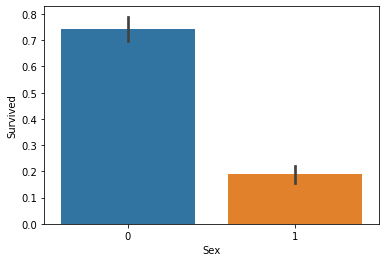

In [0]:
import seaborn as sns
sns.barplot(x='Sex', y='Survived', data=df_train)

Affichage corrélation Age et Sexe par rapport au critère de Survie

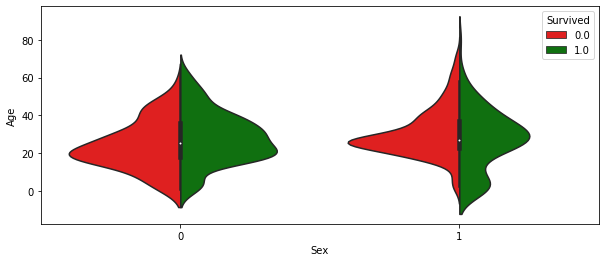

In [0]:
fig = plt.figure(figsize=(10, 4))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=df_train, 
               split=True,
               palette={0: "r", 1: "g"}
);

Affichage de la variable Fare par rapport au critère de Survie

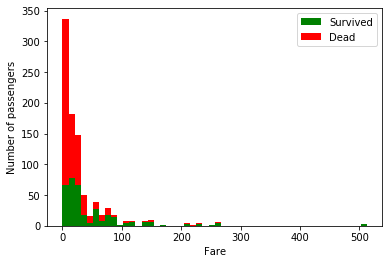

In [0]:
plt.hist([df_train[df_train['Survived'] == 1]['Fare'], df_train[df_train['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

Passengers with cheaper ticket fares are more likely to die. Put differently, passengers with more expensive tickets, and therefore a more important social status, seem to be rescued first.

**MLP**

In [0]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier(hidden_layer_sizes=(14,),
                                       activation='tanh',
                                       solver='adam',
                                       batch_size=int(0.05*len(df_train)),
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)
#Entrainement du modèle
mlp.fit(X_train, y_train)
scores_mlp=compute_score(mlp)

Accuracy score: 0.82
F1 score: 0.79
AUC score: 0.83


# ***Grid Search***

## *Random Forest*

In [0]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10, 100, 300, 500, 1000],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 
                  'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 6}
    
    rf_best = RandomForestClassifier(**parameters)
    rf_best.fit(X_train, y_train)
    scores_rf3=compute_score(rf_best)


Accuracy score: 0.82
F1 score: 0.80
AUC score: 0.83


## *Logistical Regression*

In [0]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'penalty' : ['l2', 'none'],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }
    Lr2 = LogisticRegression(solver='lbfgs')
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(Lr2,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'penalty' : 'l2', 'C': 100}
    
    Lr_best = LogisticRegression(**parameters)
    Lr_best.fit(X_train, y_train)
    scores_lr2=compute_score(Lr_best)

Accuracy score: 0.82
F1 score: 0.80
AUC score: 0.84


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

***Gradient Boosting***

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

Gb = GradientBoostingClassifier(n_estimators=500)

Gb.fit(X_train, y_train)
scores_gb= compute_score(Gb)

Accuracy score: 0.83
F1 score: 0.95
AUC score: 0.96


In [0]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'loss': ['deviance', 'exponential'],
                 'learning_rate': [0.05, 0.06, 0.07, 0.09, 0.1],
                 'n_estimators': [500, 600, 700]
                 }
    Gb2 = GradientBoostingClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(Gb2,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'loss': 'exponential','learning_rate' : 0.05,  'n_estimators':500}
    
    Gb_best = GradientBoostingClassifier(**parameters)
    Gb_best.fit(X_train, y_train)
    scores_gb2=compute_score(Gb_best)

Accuracy score: 0.84
F1 score: 0.90
AUC score: 0.91


### **XG Boost**

In [0]:
from xgboost import XGBClassifier

XGb = XGBClassifier()
XGb.fit(X_train, y_train)

scores_XGb=compute_score(XGb)

Accuracy score: 0.83
F1 score: 0.84
AUC score: 0.87


In [0]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'eta': [0.001, 0.005,0.01, 0.3],
                 'max_depth': [7]
                 }
    xgb = XGBClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(xgb,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'booster': 'gbtree', 'eta': 0.001, 'max_depth': 7}
    
    XGb_best = XGBClassifier(**parameters)
    XGb_best.fit(X_train, y_train)
    scores_XGb2=compute_score(XGb_best)

Accuracy score: 0.83
F1 score: 0.92
AUC score: 0.93


'\nXGb_test =XGBClassifier(**parameters)\nXGb_test.fit(X_train_reduced, y_train)\nscores_XGb_test=compute_score(XGb_test, x_train= X_train_reduced)\n'

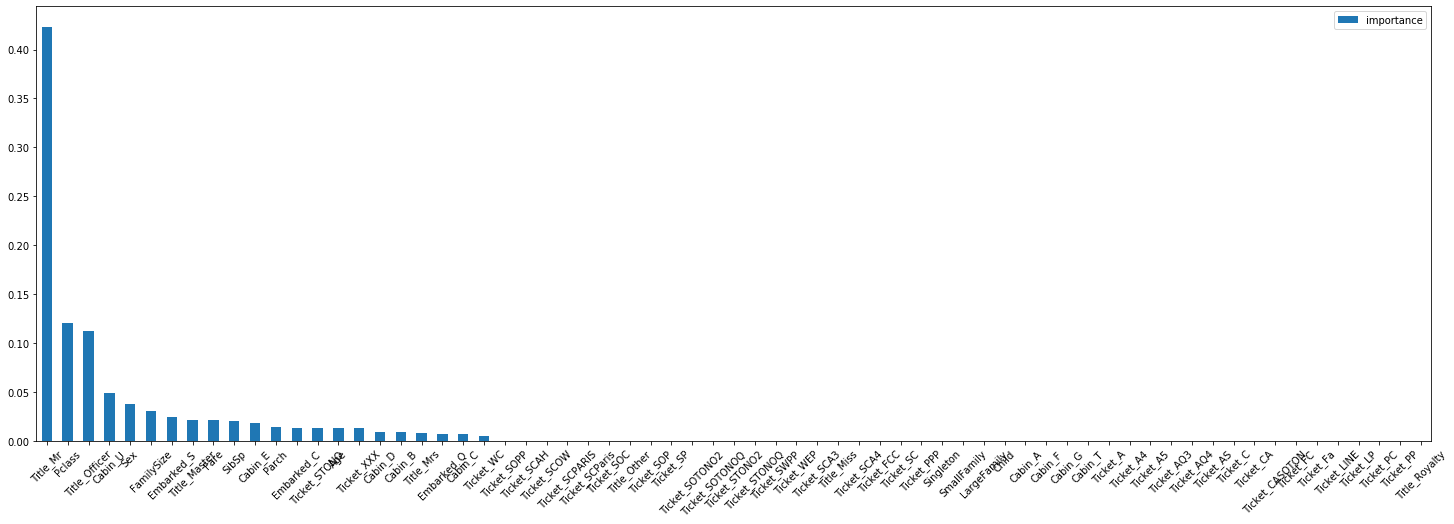

In [0]:
feature_importances = pd.DataFrame(XGb.feature_importances_,
                                   index = X_train.columns,
columns=['importance']). sort_values('importance', ascending=False)

feature_importances.plot(kind='bar',figsize=(25,8),rot =45)


"""
XGb_test =XGBClassifier(**parameters)
XGb_test.fit(X_train_reduced, y_train)
scores_XGb_test=compute_score(XGb_test, x_train= X_train_reduced)
"""

In [0]:
model = SelectFromModel(XGb, prefit=True)
X_train_reduced = model.transform(X_train)
print (X_train_reduced.shape)

X_test_reduced = model.transform(X_test)

XGb_test =XGBClassifier(**parameters)
XGb_test.fit(X_train_reduced, y_train)
scores_XGb_test=compute_score(XGb_test, x_train= X_train_reduced)

(891, 11)
Accuracy score: 0.82
F1 score: 0.87
AUC score: 0.89


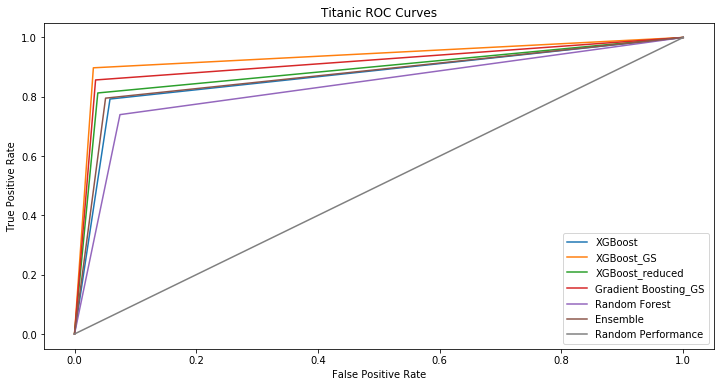

In [0]:
from sklearn.metrics import roc_curve

def plot_ROC_curves(classifiers, classifiers_name):

  fig, ax = plt.subplots(1, figsize=(12, 6))
  
  for clf, name in zip(classifiers, classifiers_name):

    if(name[-7:]=='reduced'):
      y_pred=clf.predict(X_train_reduced)
    else:
      y_pred=clf.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    plt.plot(fpr, tpr, label=name)

  plt.plot([0, 1], [0, 1], color='gray', label='Random Performance')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Titanic ROC Curves')
  plt.legend(loc="lower right")

plot_ROC_curves([XGb,XGb_best,XGb_test, Gb_best, rf_best, ensemble], ['XGBoost','XGBoost_GS','XGBoost_reduced','Gradient Boosting_GS', 'Random Forest', 'Ensemble'])

In [0]:
print(scores_XGb[-1])

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       549
         1.0       0.89      0.79      0.84       342

    accuracy                           0.88       891
   macro avg       0.89      0.87      0.87       891
weighted avg       0.89      0.88      0.88       891



# **Test Fusion d'Algos par Vote**

In [0]:
from sklearn.ensemble import VotingClassifier

xgb_ens=XGBClassifier()
parameters_rf = {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 
                  'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 6}

parameters_gb = {'loss': 'exponential','learning_rate' : 0.05,  'n_estimators':500}
    
rf_ens = RandomForestClassifier(**parameters_rf)
gb_ens = GradientBoostingClassifier(**parameters_gb)



estimators=[]
estimators.append(('XGBoost', xgb_ens))
estimators.append(('Random Forest GS', rf_ens))
estimators.append(('Gb', gb_ens))
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)
scores_ens= compute_score(ensemble)



Accuracy score: 0.84
F1 score: 0.85
AUC score: 0.88


## **Ranking des méthodes de Machine Learning**

In [0]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Logistic Regression Optimized','Support Vector Machines', 
              'Random Forest','Random Forest Optimized', 'Multi-Layers Perceptron', 'Gradient Boosting', 'Gradient Boosting Optimized', 'XGBoost', 'XGBoost_GS', 'XGBoost_reduced', 'Ensemble (XGBoost + RF GS)'],
    'Accuracy': [scores_lr[0], scores_lr2[0], scores_svm[0], scores_rf[0], scores_rf3[0],scores_mlp[0], scores_gb[0], scores_gb2[0], scores_XGb[0], scores_XGb2[0], scores_XGb_test[0],  scores_ens[0]],
    'F1 score': [scores_lr[1], scores_lr2[1], scores_svm[1], scores_rf[1], scores_rf3[1],scores_mlp[1], scores_gb[1], scores_gb2[1], scores_XGb[1], scores_XGb2[1], scores_XGb_test[1],  scores_ens[1]],
    'AUC score':[scores_lr[2], scores_lr2[2], scores_svm[2], scores_rf[2], scores_rf3[2],scores_mlp[2], scores_gb[2], scores_gb2[2], scores_XGb[2], scores_XGb2[2], scores_XGb_test[2],  scores_ens[2]]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,F1 score,AUC score
11,Ensemble (XGBoost + RF GS),0.839525,0.854460,0.877265
7,Gradient Boosting Optimized,0.837303,0.896024,0.911058
8,XGBoost,0.832815,0.840310,0.867055
9,XGBoost_GS,0.829437,0.921922,0.933348
6,Gradient Boosting,0.829431,0.948148,0.955997
0,Logistic Regression,0.826086,0.789238,0.828588
10,XGBoost_reduced,0.824956,0.867395,0.887307
1,Logistic Regression Optimized,0.819363,0.798808,0.836257
4,Random Forest Optimized,0.818233,0.795597,0.832542
3,Random Forest,0.818201,0.953101,0.956883


# **Upload des Résultats**

In [0]:
predictions=ensemble.predict(X_test)


#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
submission = pd.DataFrame({'PassengerId':df_test['PassengerId'],'Survived':predictions})
submission['Survived']=submission['Survived'].apply(int)
#Visualize the first 5 rows
print(submission.head(5))


#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Titanic Predictions Ensemble.csv'

submission.to_csv("/content/gdrive/My Drive/Kaggle/Titanic/"+filename,index=False)

print('Saved file: ' + filename)


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
Saved file: Titanic Predictions Ensemble.csv
